In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import make_interp_spline, RegularGridInterpolator

from functools import partial

In [2]:
from pinn import BasePinn

In [3]:
torch.set_default_device('cuda')

In [4]:
class TemperaturePinn(BasePinn):
    def __init__(
        self, num_boundary_samples=64, num_interior_samples=512, device="cuda", seed=0
    ):
        self.num_outputs = 2
        super().__init__(self.num_outputs, num_boundary_samples, num_interior_samples, device, seed)



        #Cached values
        self.cached_boundary = self.sample_boundaries(use_cached=False)

    def inflow_solution(self, n_samples):
        return torch.ones((n_samples)) * self.t_0

    def sample_inflow(self, n_samples):
        samples = self.sample_inflow_points(n_samples)
        values = self.inflow_solution(n_samples)

        return samples, values

    def sample_boundaries(self, use_cached=False):
        
        if use_cached and self.cached_boundary is None:
            raise RuntimeError("No cached boundary points")

        if use_cached:
            return self.cached_boundary

        return self.sample_inflow(self.num_boundary_samples)


    def compute_boundary_error(self, use_cached=False):
        points, values = self.sample_boundaries(use_cached)

        out = self.eval(points)

        return out[:, 1] - values
        

    # Compute error with some input/output pair e.g. on the boundaries or as part of supervised training
    def compute_supervised_error(self, points, values):
        out = self.eval(points)

        assert(values.shape == out.shape)
        
        return out - values
        


    # Compute error according to the PDE of the interior
    def compute_unsupervised_error(self, points, power_map, flow_field, rho=None):
        if rho is not None:
            print("WARNING: rho is not used")
        
        points.requires_grad = True

        u = torch.tensor(flow_field(points.cpu().detach().numpy()), dtype=torch.float32).to(self.device).T
        q_in = torch.tensor(power_map(points.cpu().detach().numpy())).to(self.device).T

        t = self.eval(points)


        substrate_T = t[:, 0]

        grad_substrate_T = torch.autograd.grad(substrate_T.sum(), points, create_graph=True)[0]
        
        substrate_T_x = grad_substrate_T[:, 0]
        substrate_T_y = grad_substrate_T[:, 1]

        substrate_T_xx = torch.autograd.grad(substrate_T_x.sum(), points, create_graph=True)[0][:, 0]      
        substrate_T_yy = torch.autograd.grad(substrate_T_y.sum(), points, create_graph=True)[0][:, 1]   

        channel_T = t[:, 1]

        grad_channel_T = torch.autograd.grad(channel_T.sum(), points, create_graph=True)[0]
        
        channel_T_x = grad_channel_T[:, 0]
        channel_T_y = grad_channel_T[:, 1]

        channel_T_xx = torch.autograd.grad(channel_T_x.sum(), points, create_graph=True)[0][:, 0]      
        channel_T_yy = torch.autograd.grad(channel_T_y.sum(), points, create_graph=True)[0][:, 1]   

        div_grad_substrate_T = substrate_T_xx + substrate_T_yy
        div_grad_channel_T = channel_T_xx + channel_T_yy

        termA = 2/3 * self.rho_l * self.C_f * self.U / self.L * torch.sum(u * grad_channel_T, dim=-1)
        termB = - 49/self.L**2 * self.k_t / 52 * div_grad_channel_T
        termC =  - 1 / (2 * self.H_t) * self.h_b * self.h_t / (self.h_b + self.h_t)*(substrate_T - channel_T)

        termD = -1/self.L**2 * self.k_b/2 * div_grad_substrate_T
        termE = 1 / (2 * self.H_b) * self.h_b * self.h_t / (self.h_b + self.h_t)*(substrate_T - channel_T)
        termF = - 1 / (2 * self.H_b) * q_in

        # print("A", termA, "B", termB, "C", termC, "D", termD, "E", termE, "F", termF)
        # print("A", termA.shape, "B", termB.shape, "C", termC.shape, "D", termD.shape, "E", termE.shape, "F", termF.shape)


        return (10e-7)**2 * torch.cat([termA + termB + termC, termD + termE + termF], 0)


In [5]:
num_x, num_y = 100, 100

u_x = np.loadtxt("./formatted_data99/results-99.h5_vel_0.out").reshape(num_x, num_y)
u_y = np.loadtxt("./formatted_data99/results-99.h5_vel_1.out").reshape(num_x, num_y)
u = np.stack([u_x, u_y], -1)

p_map = np.loadtxt("./formatted_data99/powermap.out").reshape(num_x, num_y)

In [6]:
def interpolate(points_out, value=None, num_x=100, num_y=100):
    x = np.arange(0 + 0.5 / num_x, 1.0, 1.0 / num_x)
    y = np.arange(0 + 0.5 / num_y, 1.0, 1.0 / num_y)

    assert value is not None

    
    interp = RegularGridInterpolator((x, y), value, bounds_error=False, fill_value=None)

    if len(value.shape) == 2:
        return interp(points_out).T

    if len(value.shape) == 3:
        return interp(points_out).T

In [7]:
num_x, num_y = 100, 100
x = np.arange(0 + 0.5 / num_x, 1.0, 1.0 / num_x)
y = np.arange(0 + 0.5 / num_y, 1.0, 1.0 / num_y)
X, Y = np.meshgrid(x, y)
points = np.array([X.flatten(), Y.flatten()]).T

(100, 100, 2)


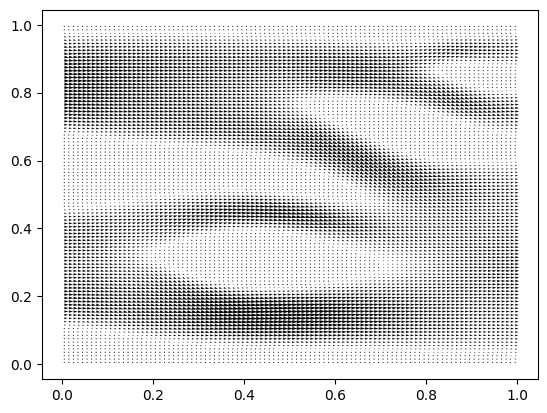

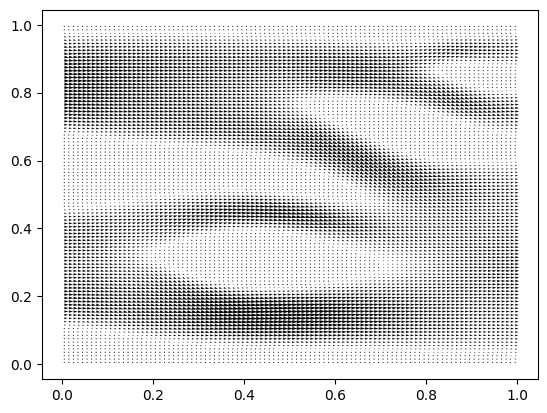

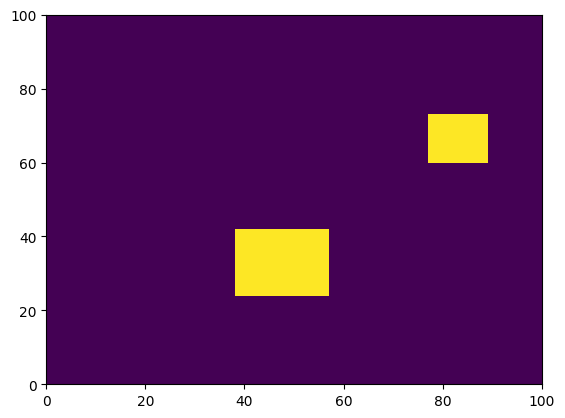

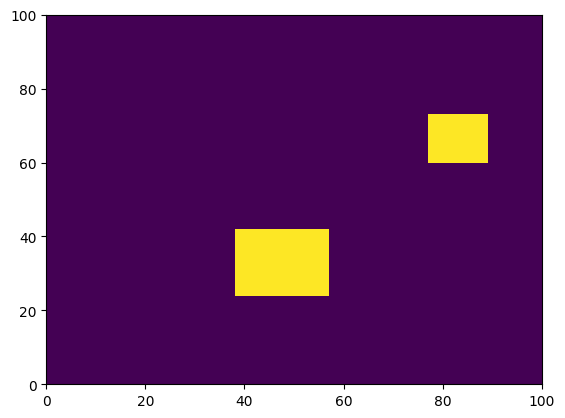

In [8]:
output = interpolate(points, u).T.reshape(num_x, num_y, 2).transpose((1, 0, 2))
print(output.shape)
plt.quiver(x, y, u_x, u_y)
plt.show()
plt.quiver(x, y, output[:, :, 0], output[:, :, 1])
plt.show()

plt.pcolormesh(p_map)
plt.show()
plt.pcolormesh(interpolate(points, p_map).reshape(num_x, num_y).T)
plt.show()

In [9]:
pinn = TemperaturePinn(
    num_boundary_samples=64, 
    num_interior_samples=512, 
    device="cuda", 
    seed=0
)

num_epochs = 1

optimizer_LBFGS = optim.LBFGS(pinn.neural_network.parameters(),
                              lr=float(0.5),
                              max_iter=150000,
                              max_eval=150000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

optimizer_ADAM = optim.Adam(pinn.neural_network.parameters(),
                            lr=float(0.0005))



In [10]:
t_substrate = np.loadtxt("./formatted_data99/results-99.h5_substrate_t_0.out")
t_channel = np.loadtxt("./formatted_data99/results-99.h5_channel_t_0.out")

data_points = torch.tensor(points, dtype=torch.float32).to('cuda')
t_combined = torch.tensor(np.stack([t_substrate, t_channel], -1).transpose((1, 0, 2)).reshape(100*100, 2), dtype=torch.float32).to('cuda')

training_data = DataLoader(
                    TensorDataset(data_points, t_combined),
                    batch_size=100 * 100,
                    shuffle=False,
                )

In [11]:
# hist = pinn.fit(num_epochs = 10,
#          optimizer = optimizer_LBFGS,
#          data=training_data,
#          verbose=True)

hist = [0.0, 1.0]


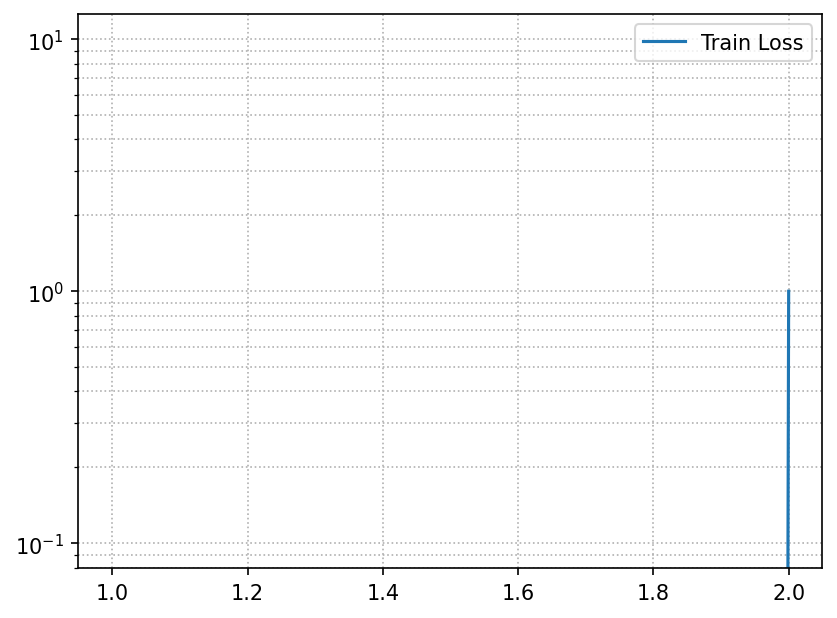

In [12]:
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
# plt.xscale("log")
plt.yscale("log")
plt.legend()

In [13]:
def plot_comparison(reference):

    inputs = pinn.sample_domain(10000)
    pred = pinn.eval(inputs)

    substrate_T = pred[:, 0]
    channel_t = pred[:, 1]

    substrate_T = substrate_T.reshape(-1, )
    channel_t = channel_t.reshape(-1, )

    fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)


    im2 = axs[0].tripcolor(inputs[:, 1].detach().cpu(), inputs[:, 0].detach().cpu(), channel_t.detach().cpu(), cmap="jet")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")
    plt.colorbar(im2, ax=axs[0], spacing='proportional')
    axs[0].grid(True, which="both", ls=":")
    axs[0].set_title("Channel Temperature")

    im2 = axs[1].pcolormesh(reference[:, :, 1], cmap="jet")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("y")
    plt.colorbar(im2, ax=axs[1])
    axs[1].grid(True, which="both", ls=":")
    axs[1].set_title("t_channel ref")

    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
    im1 = axs[0].tripcolor(inputs[:, 1].detach().cpu(), inputs[:, 0].detach().cpu(), substrate_T.detach().cpu(), cmap="jet")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")
    plt.colorbar(im1, ax=axs[0], spacing='proportional')
    axs[0].grid(True, which="both", ls=":")
    axs[0].set_title("Substrate Temperature")

    im1 = axs[1].pcolormesh(reference[:, :, 0], cmap="jet")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("y")
    plt.colorbar(im1, ax=axs[1])
    axs[1].grid(True, which="both", ls=":")
    axs[1].set_title("t_substrate ref")

    print(reference.shape)

    # print("Data stats:", np.mean(reference[:, :, 0]), 
    #                      np.std(reference[:, :, 0]), 
    #                      np.mean(reference[:, :, 1]), 
    #                      np.std(reference[:, :, 1]))



    plt.show()

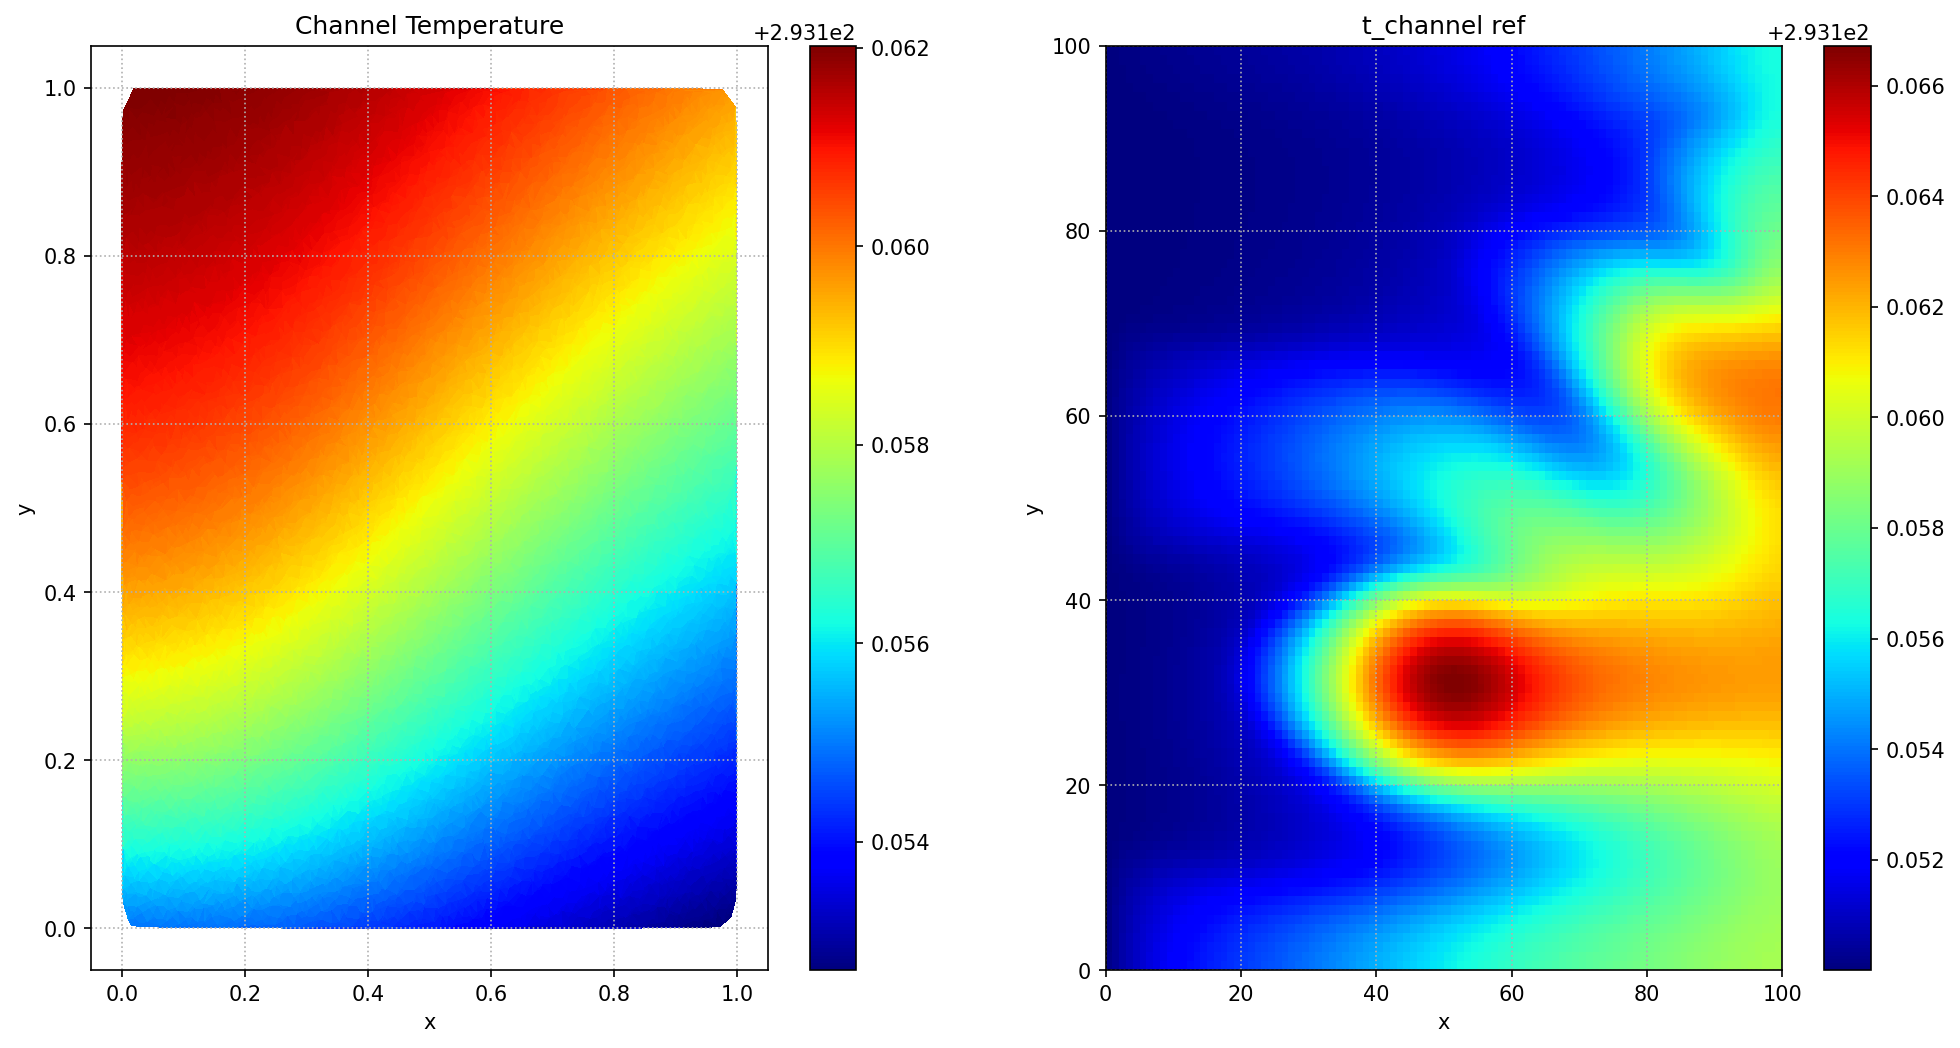

(100, 100, 2)


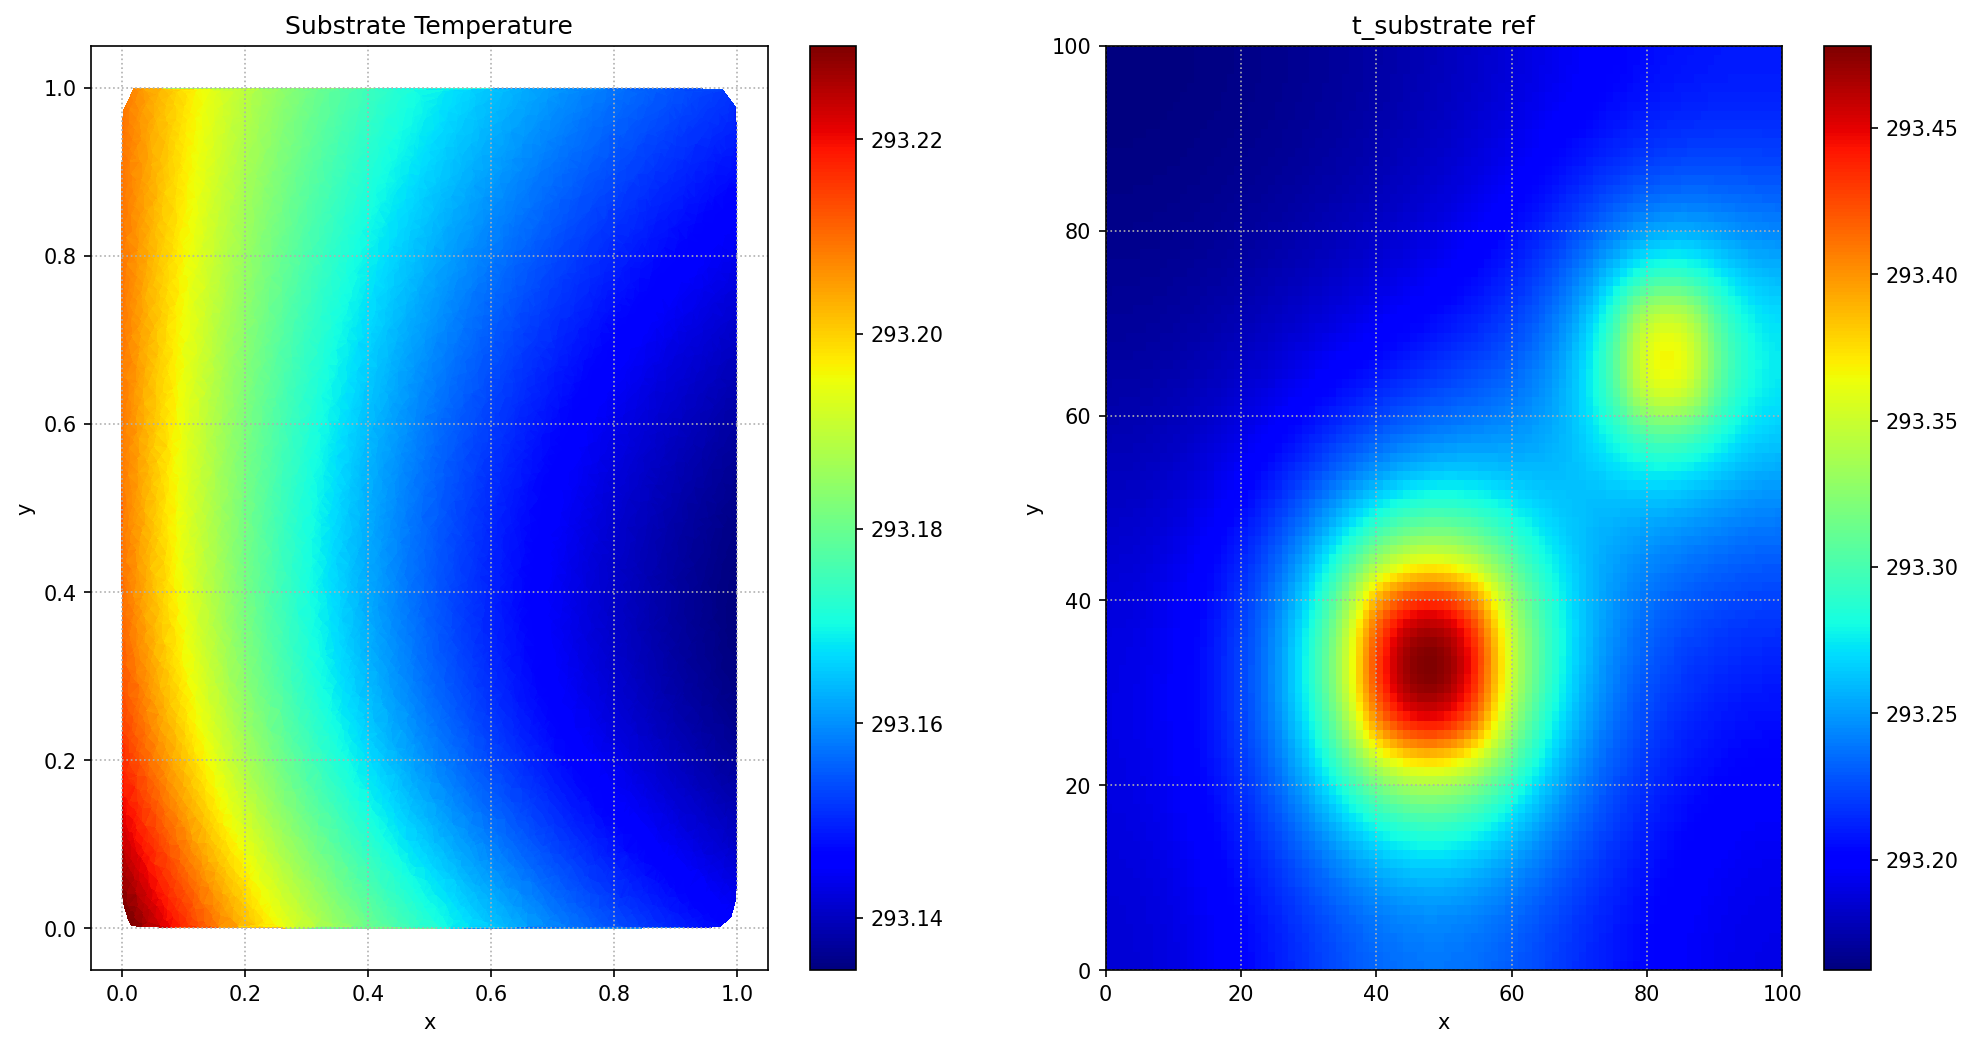

In [14]:
plot_comparison(np.stack([t_substrate, t_channel], -1).reshape(100, 100, 2))

In [15]:


hist = pinn.fit(num_epochs = num_epochs,
         optimizer = optimizer_LBFGS,
         power_map=partial(interpolate, value=p_map),
         flow_field=partial(interpolate, value=u),
         use_cached_data=False,
         verbose=True)





################################  0  ################################


/home/steinraf/Apps/firedrake/firedrake/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  return func(*args, **kwargs)


Total loss:  28.3417 | Boundary Error:  0.0 | Interior Error:  2035318066811.7698 | Regularization Error:  11.3386
Total loss:  28.2946 | Boundary Error:  0.0 | Interior Error:  1941754325635.2146 | Regularization Error:  11.3386
Total loss:  28.0712 | Boundary Error:  0.0 | Interior Error:  1552914702290.2502 | Regularization Error:  11.3386
Total loss:  26.6097 | Boundary Error:  0.0 | Interior Error:  360132689624.025 | Regularization Error:  11.3384
Total loss:  26.5454 | Boundary Error:  0.0 | Interior Error:  337690172114.5375 | Regularization Error:  11.3384
Total loss:  26.5192 | Boundary Error:  0.0 | Interior Error:  328968516095.1557 | Regularization Error:  11.3384
Total loss:  26.4673 | Boundary Error:  0.0 | Interior Error:  312320625816.5783 | Regularization Error:  11.3384
Total loss:  26.4504 | Boundary Error:  0.0 | Interior Error:  307095661933.4967 | Regularization Error:  11.3384
Total loss:  26.4445 | Boundary Error:  0.0 | Interior Error:  305284276502.4174 | Reg

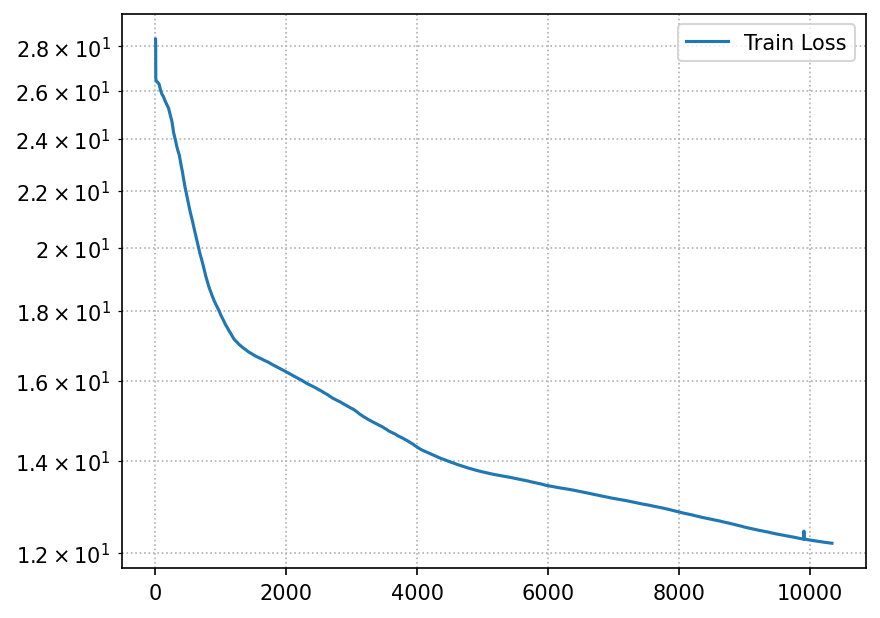

In [16]:
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.yscale("log")
plt.legend()

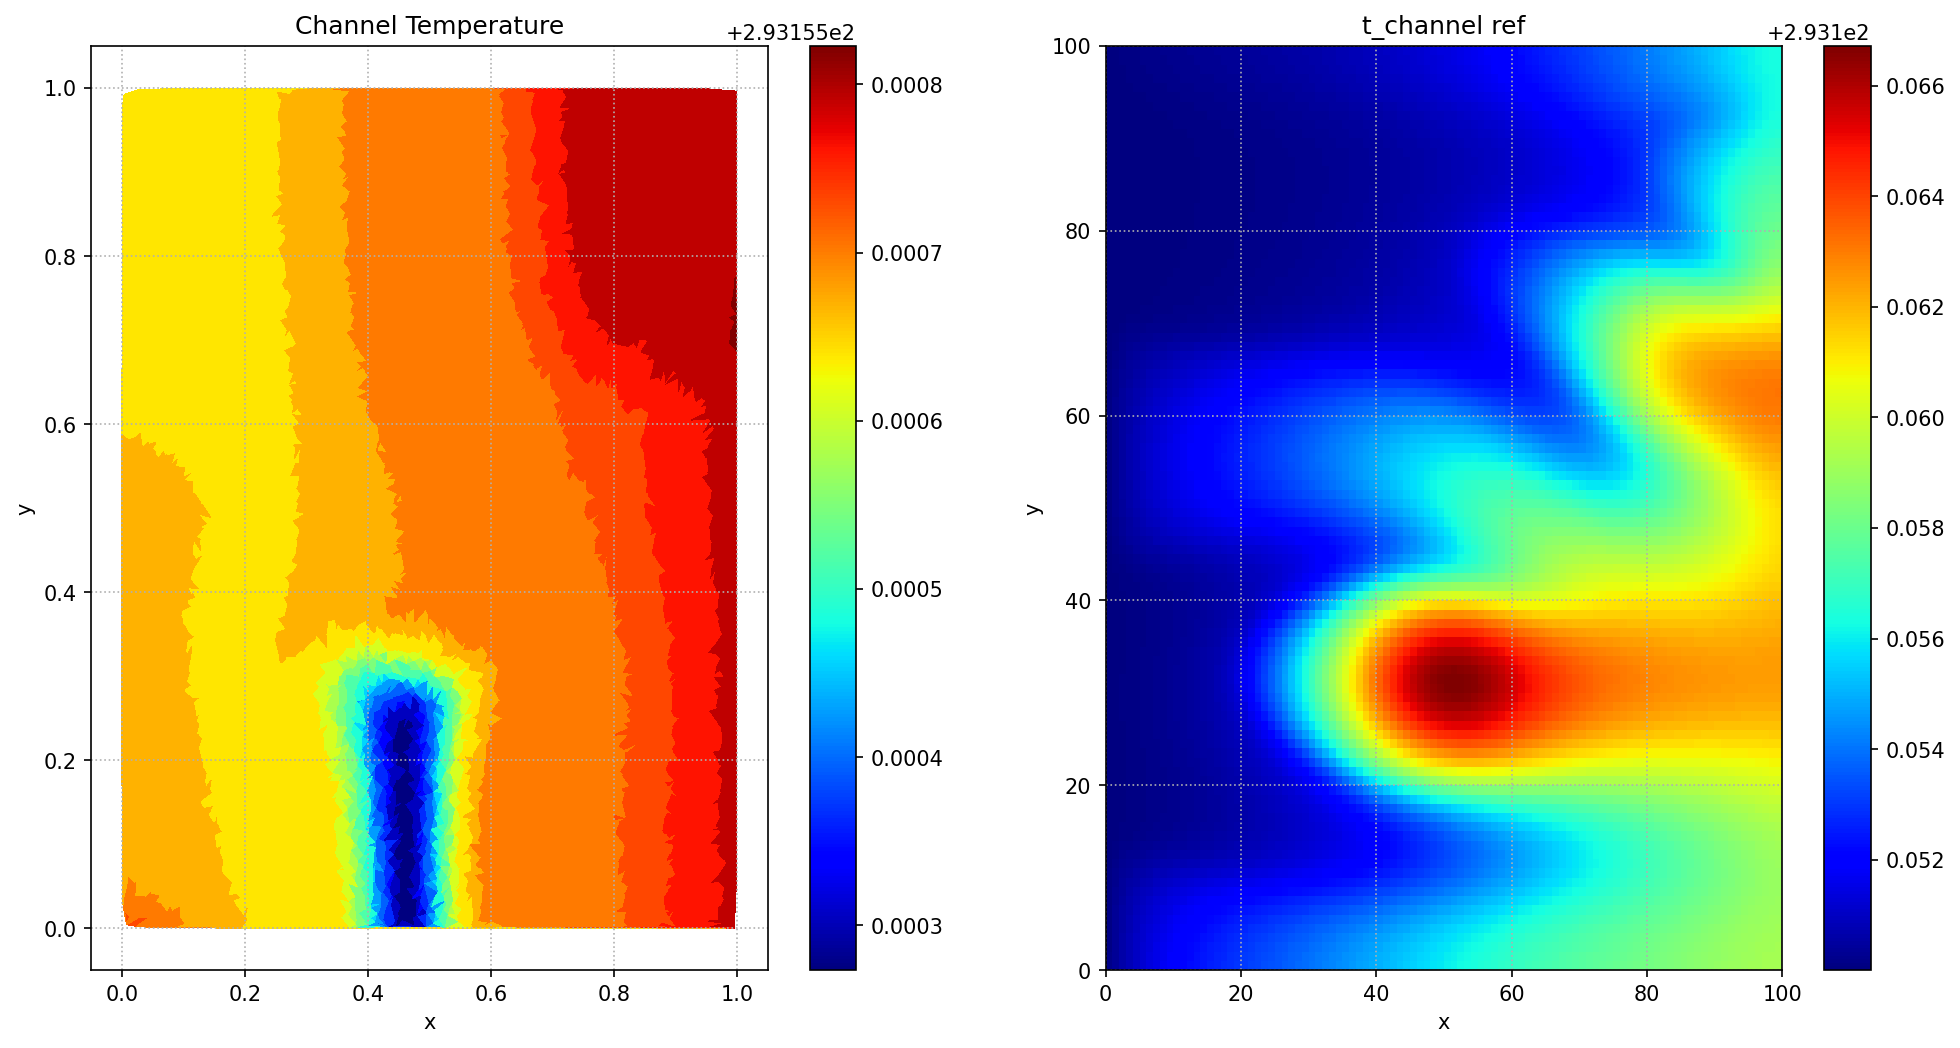

(100, 100, 2)


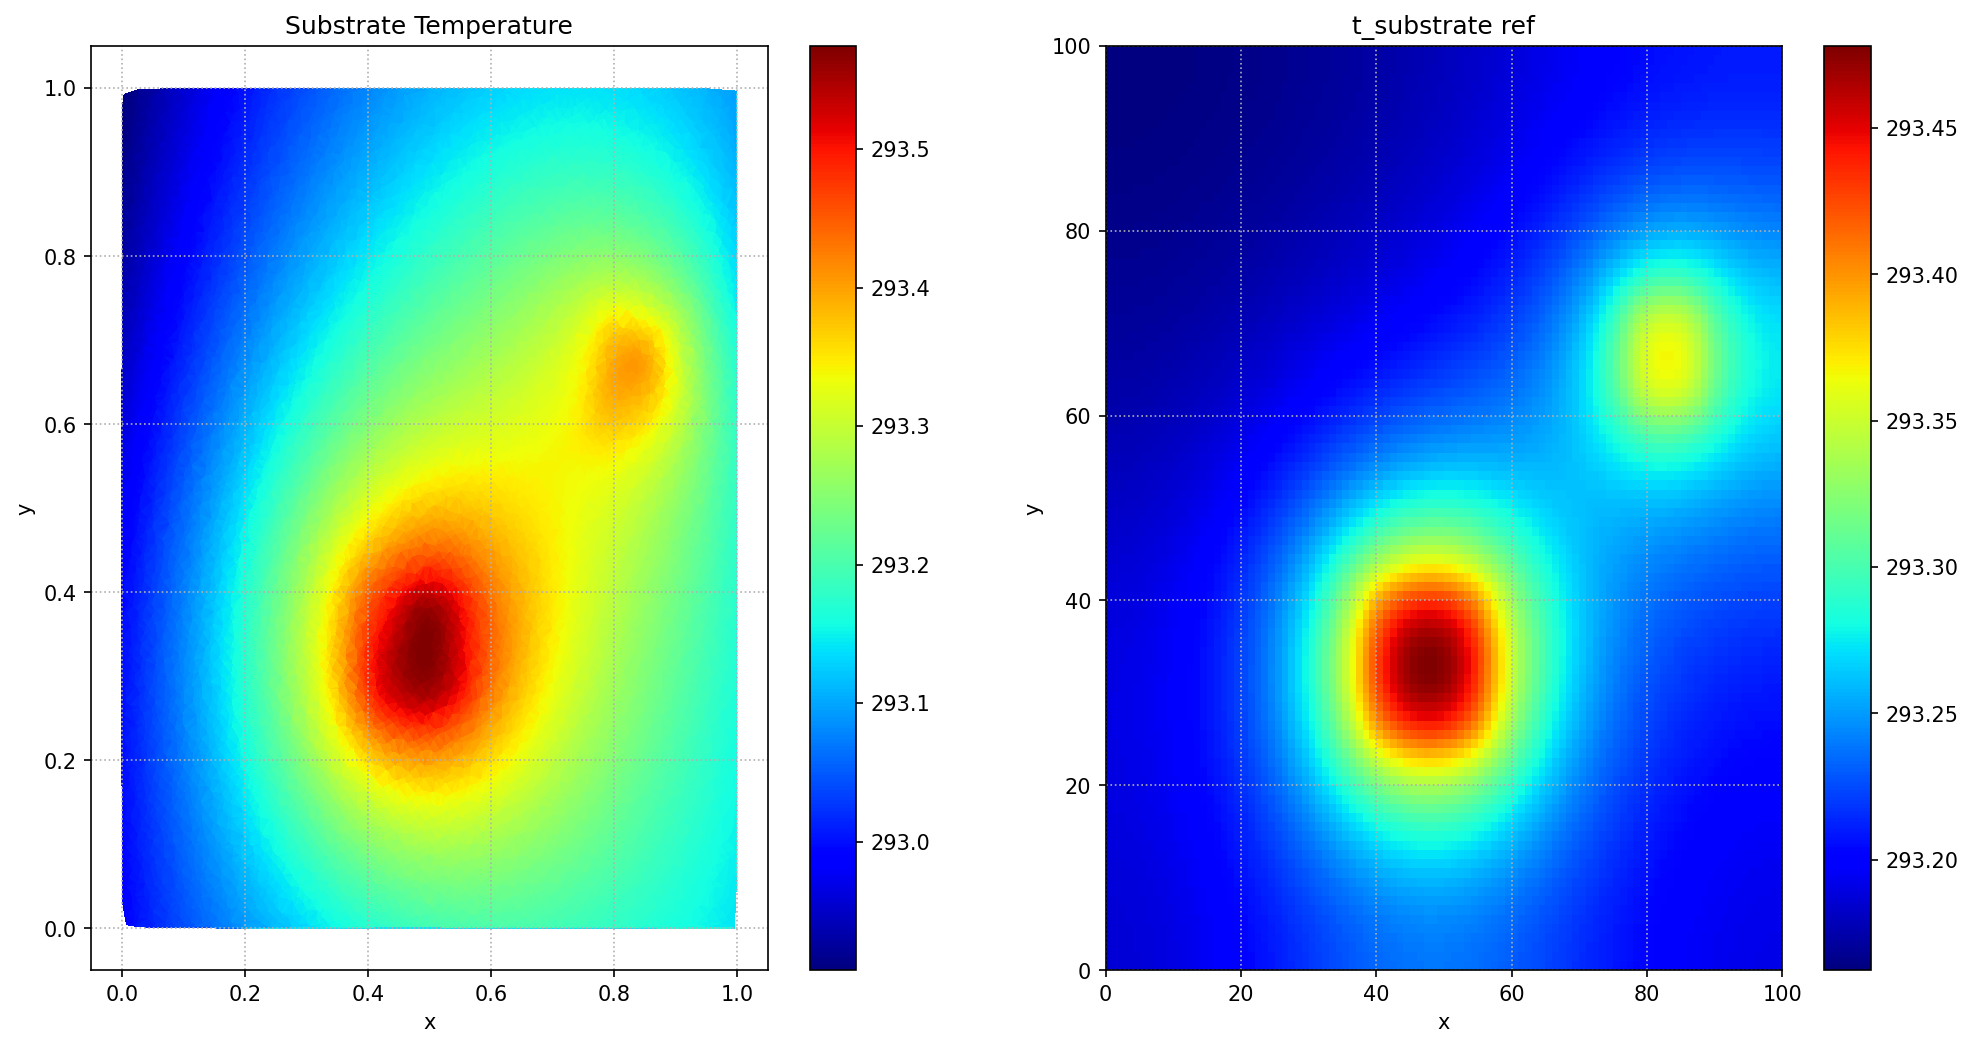

In [17]:
plot_comparison(np.stack([t_substrate, t_channel], -1).reshape(100, 100, 2))

In [18]:
# hist = pinn.fit(num_epochs = 10000,
#                 optimizer = optimizer_ADAM,
#                 power_map=partial(interpolate, value=p_map),
#                 flow_field=partial(interpolate, value=u),
#                 use_cached_data=False,
#                 verbose=True)

hist = [0.0, 1.0]

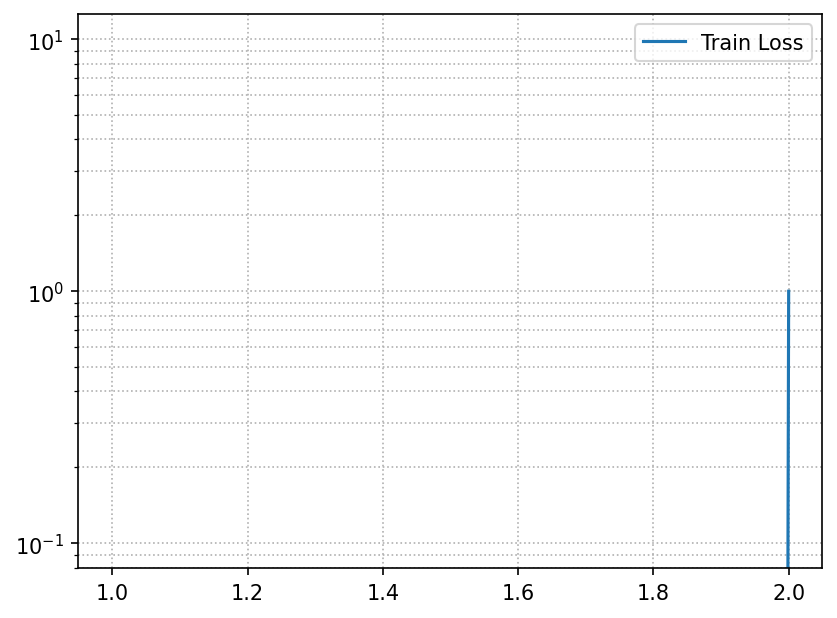

In [19]:
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.yscale("log")
plt.legend()

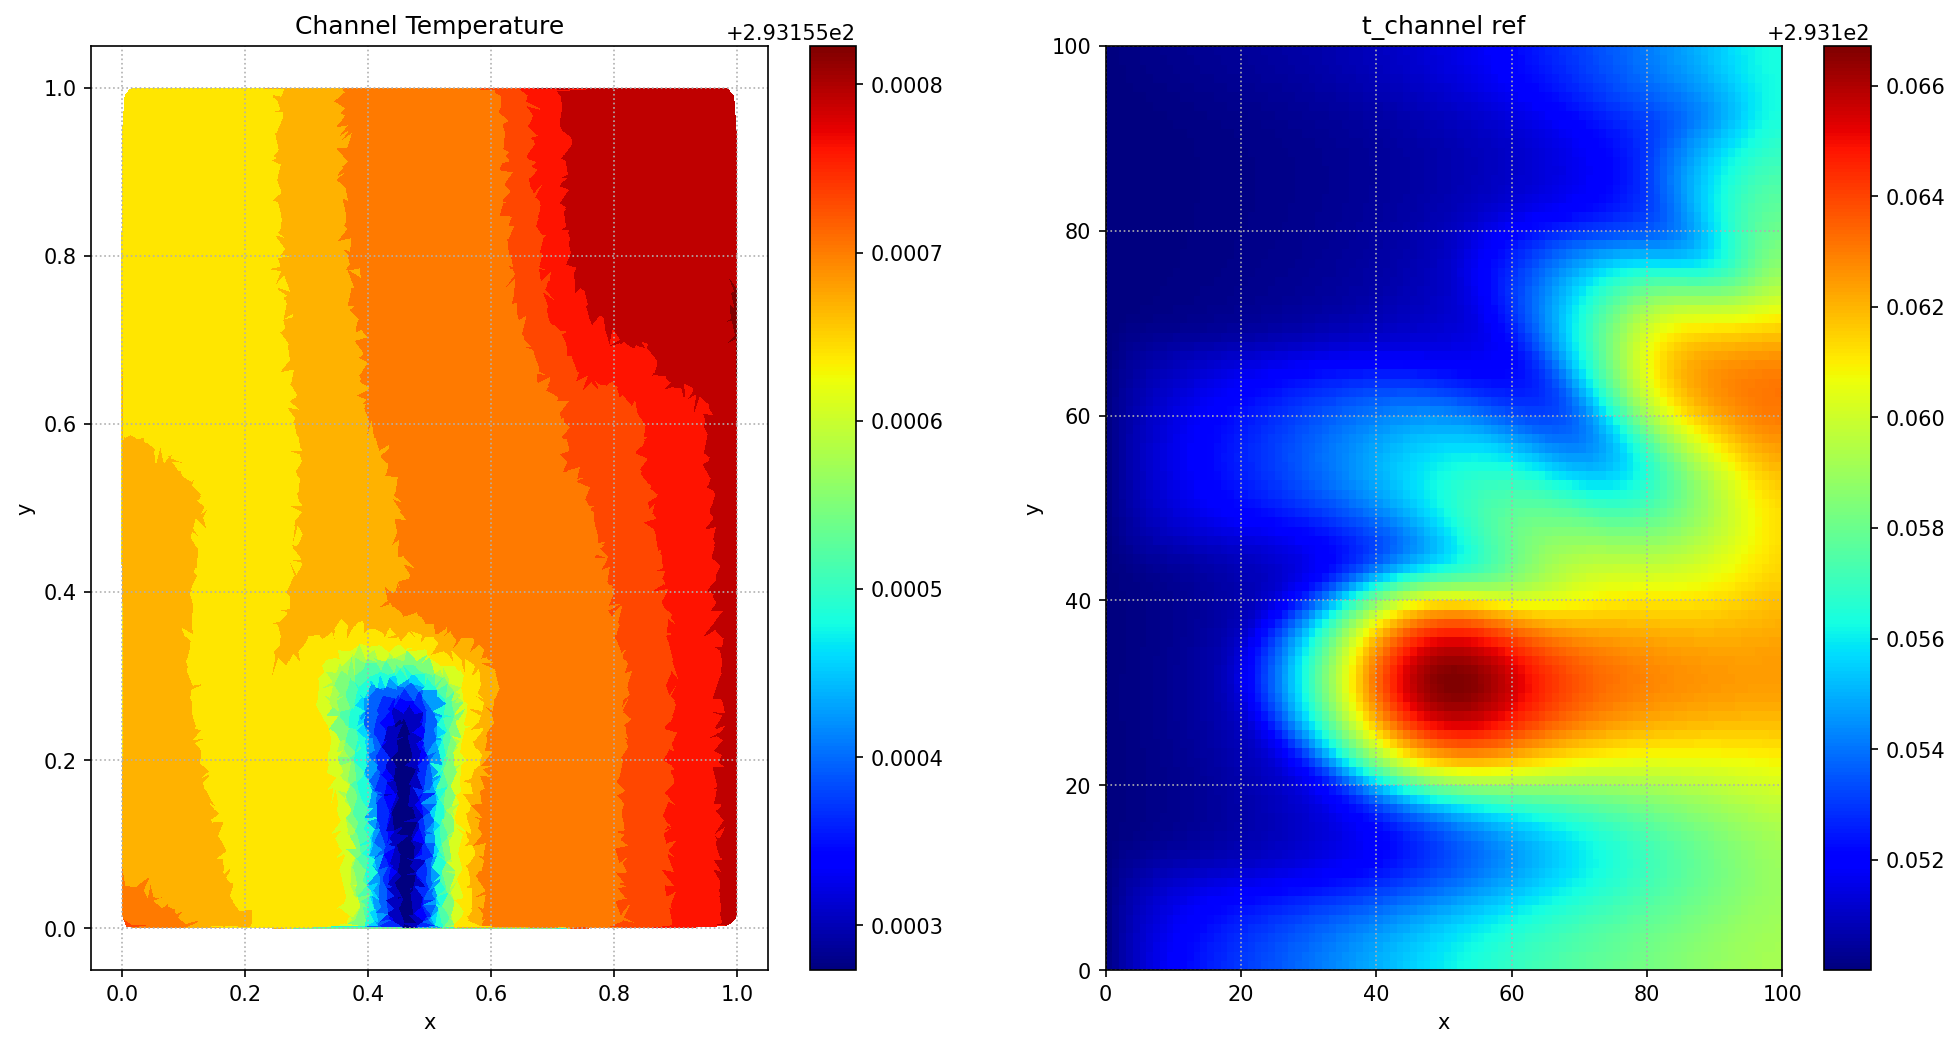

(100, 100, 2)


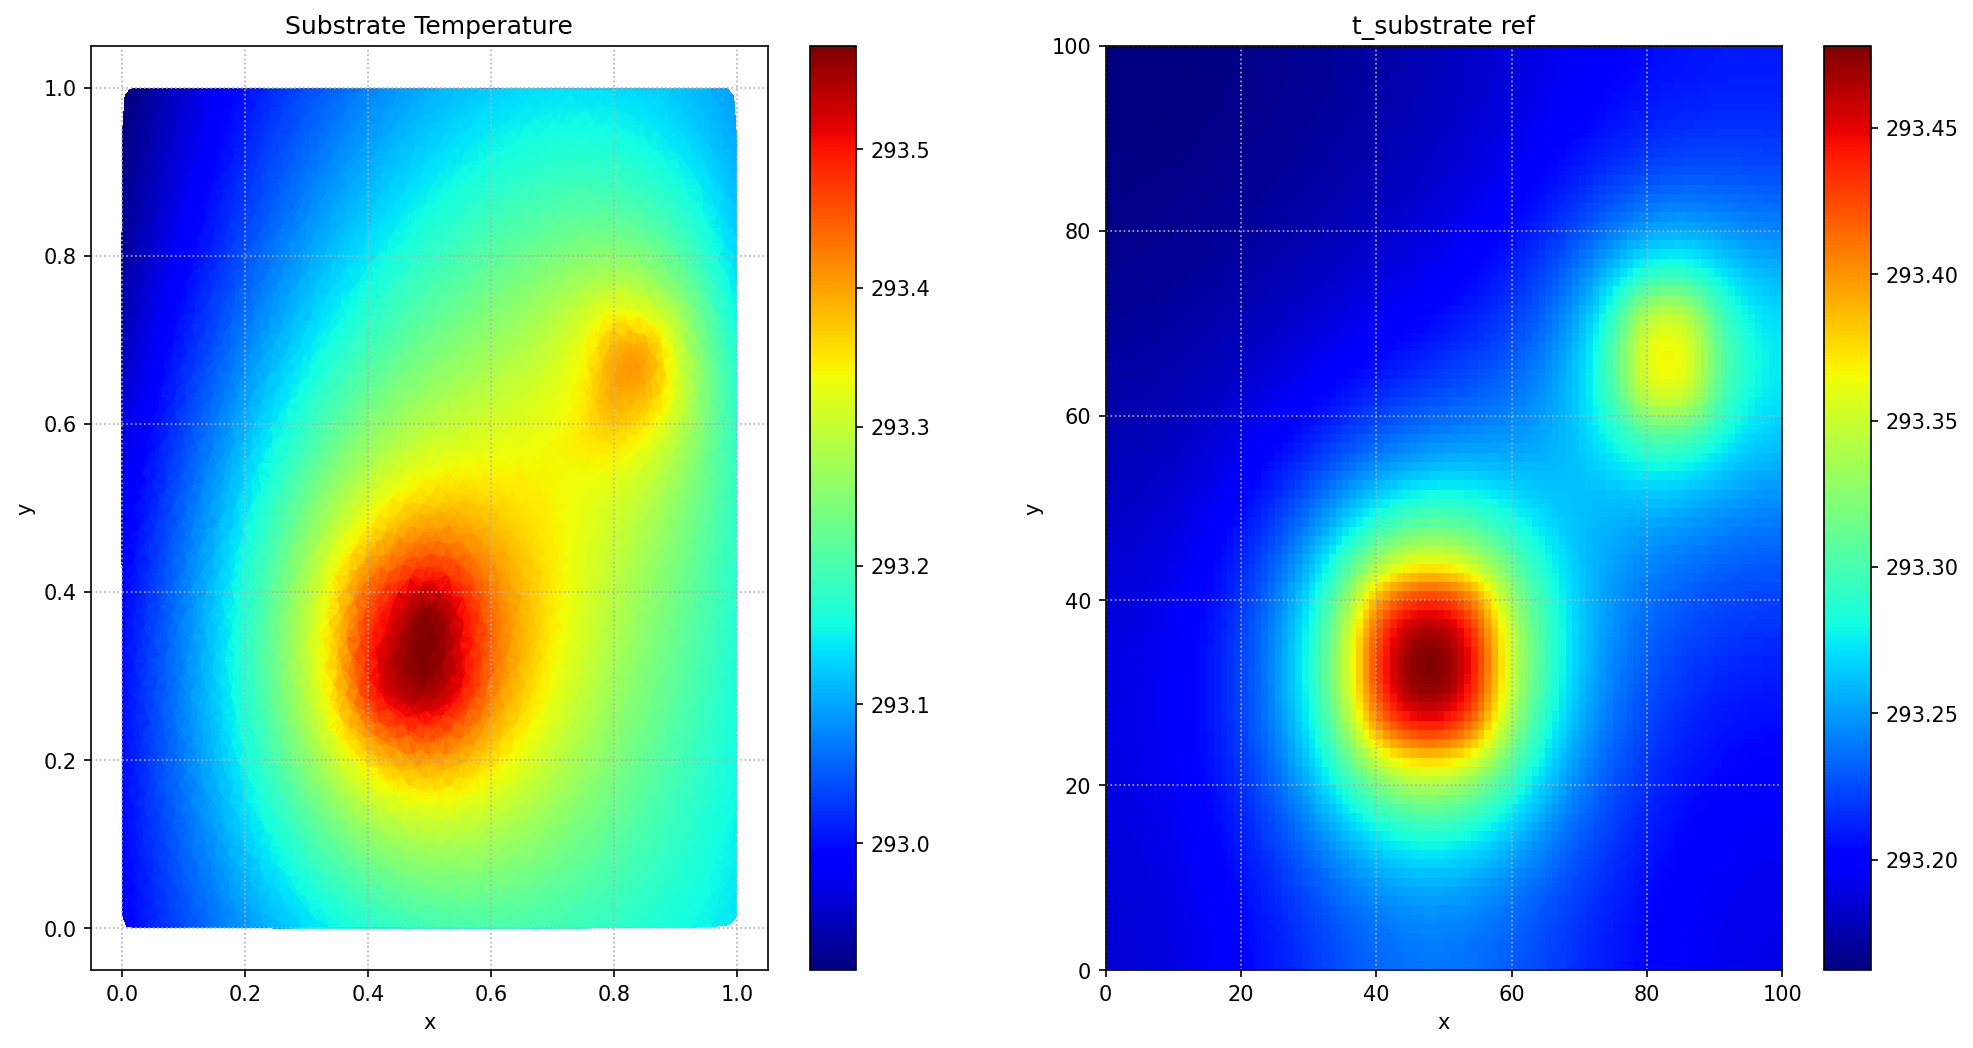

In [20]:
plot_comparison(np.stack([t_substrate, t_channel], -1).reshape(100, 100, 2))